In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def load_image_grayscale(path):
    img = Image.open(path).convert('L')  # Convert to grayscale
    img_np = np.array(img).astype(np.float32) / 255.0  # Normalize to [0, 1]
    return img_np

In [5]:
def compute_fft2(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    return fshift

In [ ]:
def generate_circular_masks(shape, grid_size, radius, overlap=0.15):
    H, W = shape
    masks = []
    cx, cy = W // 2, H // 2  # center of frequency domain

    spacing = 2 * radius * (1 - overlap)

    x_lin = np.linspace(cx - (grid_size[1] - 1) / 2 * spacing,
                        cx + (grid_size[1] - 1) / 2 * spacing,
                        grid_size[1])
    y_lin = np.linspace(cy - (grid_size[0] - 1) / 2 * spacing,
                        cy + (grid_size[0] - 1) / 2 * spacing,
                        grid_size[0])
    xv, yv = np.meshgrid(x_lin, y_lin)

    Y, X = np.ogrid[:H, :W]
    centers = []

    # Restore original loop order: for each y (row), loop over x (column)
    for i in range(grid_size[0]):  # rows (y)
        for j in range(grid_size[1]):  # columns (x)
            center_x, center_y = int(round(xv[i, j])), int(round(yv[i, j]))
            mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
            masks.append(mask.astype(np.float32))
            centers.append([center_x - cx, center_y - cy])

    centers_px = np.array(centers, dtype=np.int32)[None, :, :]  # (1, N, 2)

    return masks, centers_px


In [24]:
def apply_mask_to_fft(fft_image, mask):
    return fft_image * mask

In [25]:
def compute_ifft2(fft_masked):
    f_ishift = np.fft.ifftshift(fft_masked)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

In [26]:
def show_image_and_spectrum(image, fft_image, title_prefix=""):
    magnitude_spectrum = np.log1p(np.abs(fft_image))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'{title_prefix}Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f'{title_prefix}FFT Magnitude')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [27]:
def visualize_masks_overlay(fft_image, masks, alpha=0.3):
    base = np.log1p(np.abs(fft_image))
    combined_mask = np.zeros_like(base)

    for mask in masks:
        combined_mask += mask

    plt.figure(figsize=(6, 6))
    plt.imshow(base, cmap='gray')
    plt.imshow(combined_mask, cmap='jet', alpha=alpha)
    plt.title("Circular Mask Grid Overlay")
    plt.axis('off')
    plt.show()

In [28]:
def display_low_res_images(images, grid_size):
    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            axs[i, j].imshow(images[idx], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f'Patch ({i},{j})')
    plt.tight_layout()
    plt.show()


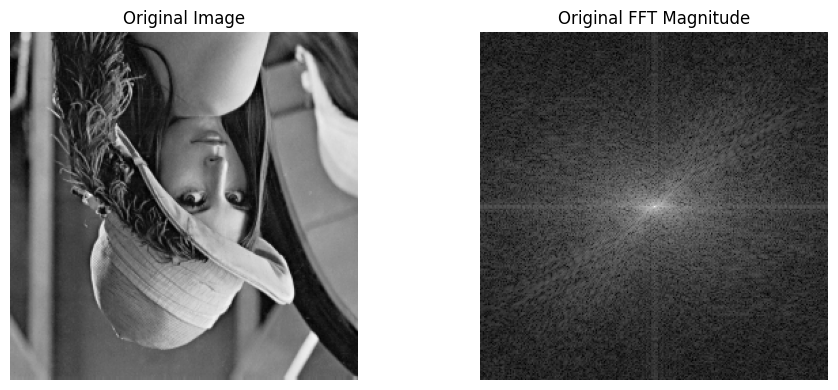

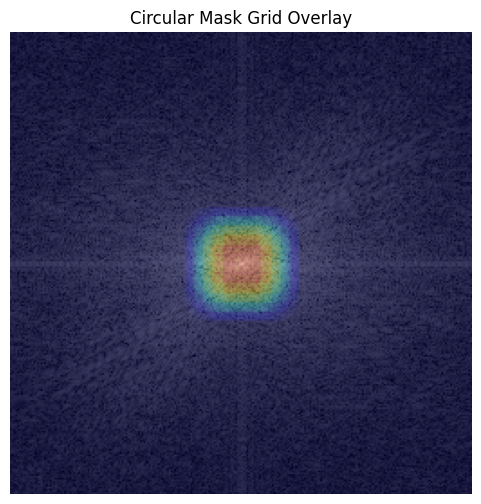

In [29]:
# Load and process image
img = load_image_grayscale(r'C:\Users\beery\OneDrive\桌面\Study\SoSe 2025 Jena\Imip\IMIP-Project\FP_Yen\image_sim.png')
fshift = compute_fft2(img)

# Show original and spectrum
show_image_and_spectrum(img, fshift, title_prefix="Original ")

# Create masks
grid_size = (8, 8)
radius = 14
masks, Ns = generate_circular_masks(img.shape, grid_size, radius, overlap=0.816)

# Visualize masks on spectrum
visualize_masks_overlay(fshift, masks)


In [30]:
Ns[0]

array([[-18, -18],
       [-18, -13],
       [-18,  -8],
       [-18,  -3],
       [-18,   3],
       [-18,   8],
       [-18,  13],
       [-18,  18],
       [-13, -18],
       [-13, -13],
       [-13,  -8],
       [-13,  -3],
       [-13,   3],
       [-13,   8],
       [-13,  13],
       [-13,  18],
       [ -8, -18],
       [ -8, -13],
       [ -8,  -8],
       [ -8,  -3],
       [ -8,   3],
       [ -8,   8],
       [ -8,  13],
       [ -8,  18],
       [ -3, -18],
       [ -3, -13],
       [ -3,  -8],
       [ -3,  -3],
       [ -3,   3],
       [ -3,   8],
       [ -3,  13],
       [ -3,  18],
       [  3, -18],
       [  3, -13],
       [  3,  -8],
       [  3,  -3],
       [  3,   3],
       [  3,   8],
       [  3,  13],
       [  3,  18],
       [  8, -18],
       [  8, -13],
       [  8,  -8],
       [  8,  -3],
       [  8,   3],
       [  8,   8],
       [  8,  13],
       [  8,  18],
       [ 13, -18],
       [ 13, -13],
       [ 13,  -8],
       [ 13,  -3],
       [ 13,

In [31]:
# Apply masks and inverse FFT
low_res_images = []
for mask in masks:
    masked_fft = apply_mask_to_fft(fshift, mask)
    low_res = compute_ifft2(masked_fft)
    low_res_images.append(low_res)

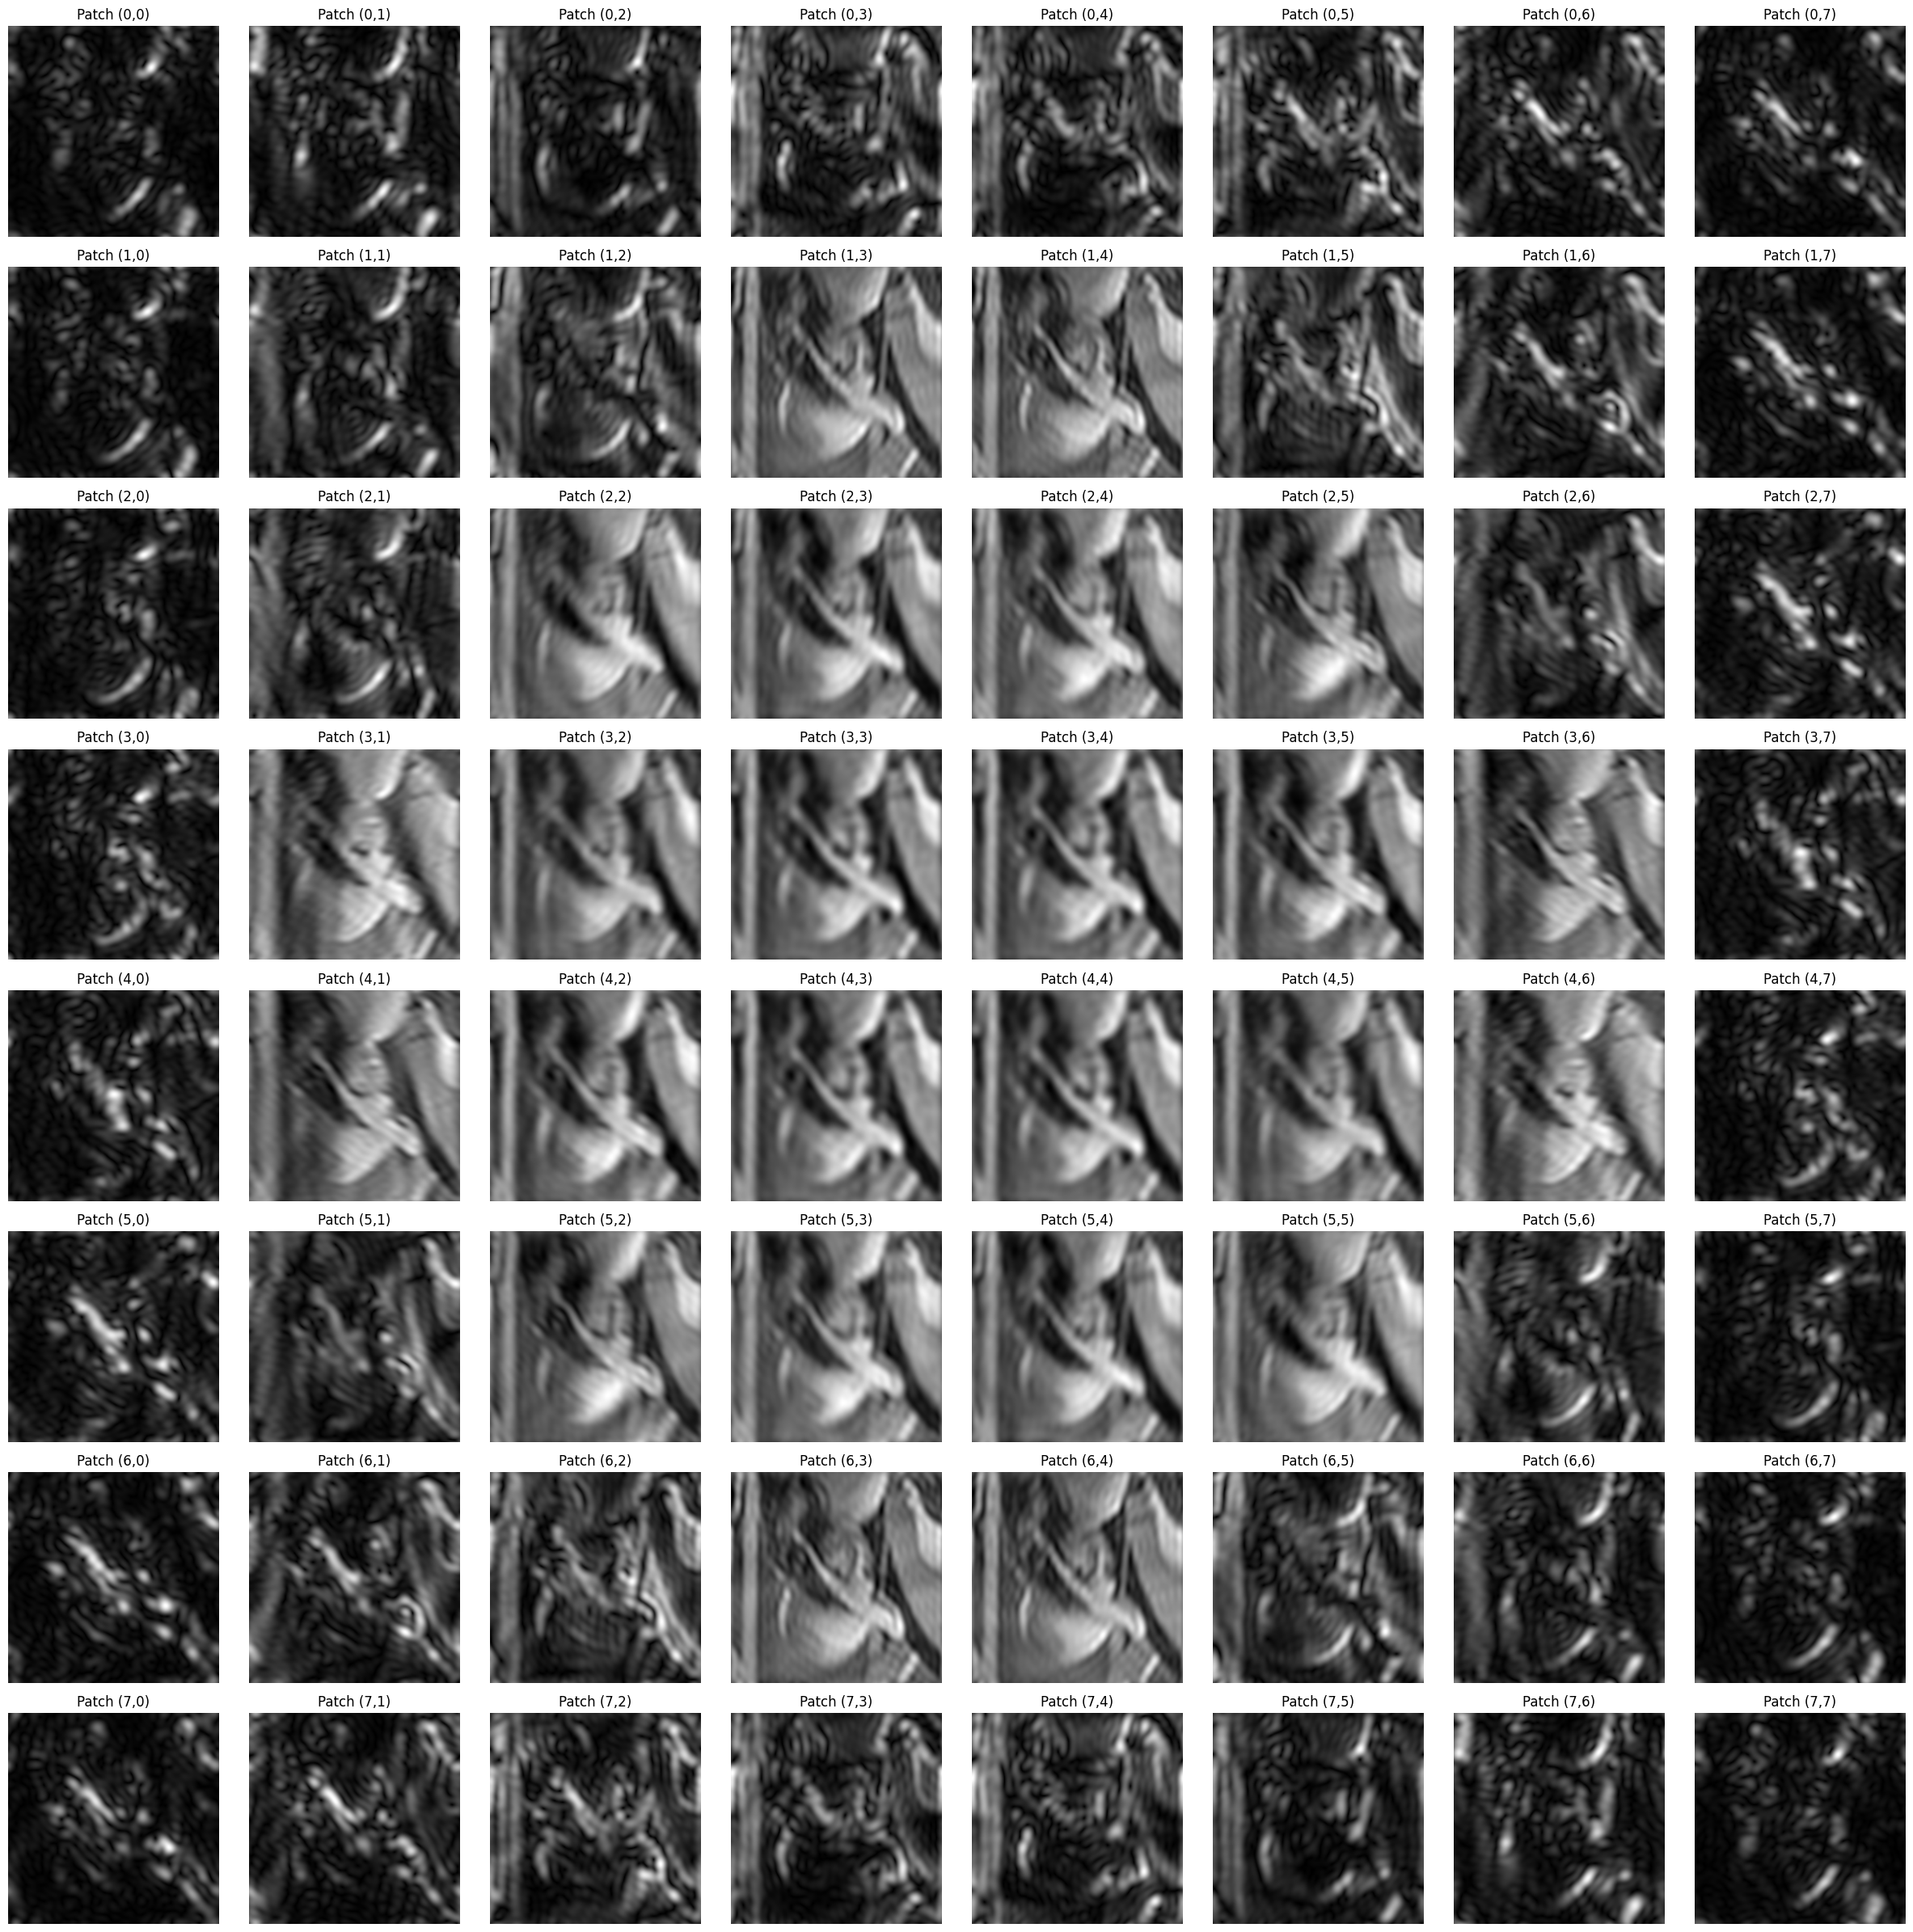

In [32]:
# Display reconstructed images
display_low_res_images(low_res_images, grid_size)

In [33]:
stacked_images = np.stack(low_res_images, axis=-1)
stacked_images.shape

(256, 256, 64)

In [22]:
# Use the Ns variable from the mask generation step
Ns[0]

array([[-18, -18],
       [-13, -18],
       [ -8, -18],
       [ -3, -18],
       [  3, -18],
       [  8, -18],
       [ 13, -18],
       [ 18, -18],
       [-18, -13],
       [-13, -13],
       [ -8, -13],
       [ -3, -13],
       [  3, -13],
       [  8, -13],
       [ 13, -13],
       [ 18, -13],
       [-18,  -8],
       [-13,  -8],
       [ -8,  -8],
       [ -3,  -8],
       [  3,  -8],
       [  8,  -8],
       [ 13,  -8],
       [ 18,  -8],
       [-18,  -3],
       [-13,  -3],
       [ -8,  -3],
       [ -3,  -3],
       [  3,  -3],
       [  8,  -3],
       [ 13,  -3],
       [ 18,  -3],
       [-18,   3],
       [-13,   3],
       [ -8,   3],
       [ -3,   3],
       [  3,   3],
       [  8,   3],
       [ 13,   3],
       [ 18,   3],
       [-18,   8],
       [-13,   8],
       [ -8,   8],
       [ -3,   8],
       [  3,   8],
       [  8,   8],
       [ 13,   8],
       [ 18,   8],
       [-18,  13],
       [-13,  13],
       [ -8,  13],
       [ -3,  13],
       [  3,

In [34]:
%load_ext autoreload
%autoreload 2
import Main_functions
from Main_functions import AlterMin

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Stepsize 0.01
# Alpha Beta are both 3
O, P, err, scale, Ns = AlterMin(stacked_images, [612,612], Ns, {})

| iter |  rmse    |
--------------------
|  0   | inf |
|  1   | 1.80e+12 |
|  1   | 1.80e+12 |
|  2   | 9.73e+10 |
|  2   | 9.73e+10 |
|  3   | 1.00e+10 |
|  3   | 1.00e+10 |
|  4   | 4.14e+09 |
|  4   | 4.14e+09 |
|  5   | 2.22e+09 |
|  5   | 2.22e+09 |
|  6   | 1.37e+09 |
|  6   | 1.37e+09 |
|  7   | 9.12e+08 |
|  7   | 9.12e+08 |
|  8   | 6.40e+08 |
|  8   | 6.40e+08 |
|  9   | 4.68e+08 |
|  9   | 4.68e+08 |
| 10   | 3.52e+08 |
| 10   | 3.52e+08 |
| 11   | 2.72e+08 |
| 11   | 2.72e+08 |
| 12   | 2.15e+08 |
| 12   | 2.15e+08 |
| 13   | 1.73e+08 |
| 13   | 1.73e+08 |
| 14   | 1.41e+08 |
| 14   | 1.41e+08 |
| 15   | 1.17e+08 |
| 15   | 1.17e+08 |
| 16   | 9.82e+07 |
| 16   | 9.82e+07 |
| 17   | 8.33e+07 |
| 17   | 8.33e+07 |
| 18   | 7.14e+07 |
| 18   | 7.14e+07 |
| 19   | 6.18e+07 |
| 19   | 6.18e+07 |
| 20   | 5.38e+07 |
| 20   | 5.38e+07 |
| 21   | 4.73e+07 |
| 21   | 4.73e+07 |
| 22   | 4.18e+07 |
| 22   | 4.18e+07 |
| 23   | 3.71e+07 |
| 23   | 3.71e+07 |
| 24   | 3.32e+07 |
| 24

Text(0.5, 1.0, 'Optimized Image')

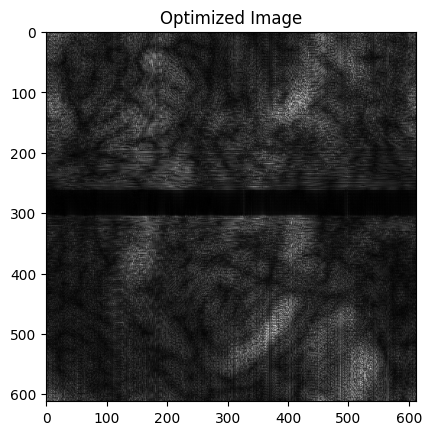

In [36]:
o_image=np.fft.ifft2(O)
plt.imshow(np.abs(o_image), cmap='gray')
# Display the optimized image
plt.title("Optimized Image")